## 这次主要是根据上次跑出来的一些结果，加入新的特征和一些小的修正
- 加入语法错误检测  ---但是没整出来，自己写的方法不太好
- 修正错误单词拼写
- 修正大小写规则
- 主题个数特征 ---没加入


## 分析结果
我找了一些评分差距比较大的文章，现在把评分结果分析记录在这里

### essay1:
Dear Jerry, Hi, Jerry. For you thing. I think I can give you a little help. Frist, yours title must have attractive. Then, you must yours talking I will conclude by say:Fighting!you extreedly. great ! ' Yours,

- 预测评分 8.5 
- 实际评分 2.5 

我们可以看出，标点使用十分不规范，语法错误较多，而且结尾没有以lihua结尾--这也说明，我们需要针对不同的评分文本做具体的分析

### essay2：
Dear Jerry, T will try my best to help you. First, You must know what you should say. And you must keep smile, You can't walk around, secend, you should try you best to say that want to say. Don't let students think you. fool'sh. You can ask teacher your problem, when the yanjiang ending, you should limao leave, Li Hua belive yourself, you can do that good. Every think will good. Yours. Li Hua

- 预测得分：10.8 
- 实际得分：7.0

可以看出，语法错误较多，标点符号错误较多，还用到了拼音，但是这些机器都没有检查出来

### essay 3：
Dear Jerry Hallo. The talking English is very interesting. Frish. You can writing about the talking. Don't anxiety. It's also true that nobaly is born knowing How to use knives and forks correctly. In turn we can take the opportunity to teach them some thing about our one culture. We've to learn How to drive here to wear proper clothing and so on. Finely, you can Li Mao live. You can underctand.? Yours, Li Hua

- 预测得分：7.3
- 实际得分：4.5

可以看出，拼写错误多，标点符号使用错误多，语法错误多，所以之后一定要把拼写错误这一条加进去

### essay 4:
Dear Jerry, Hello, Jerry. Long time no see. I'm Li Hua. How are you? I need your help Yours, Li Hua

- 预测得分：9
- 实际得分：0.5

这个得分太离谱了，这个文章没有主题，字数太少，但是预测得分还很高，所以后面需要加入主题个数特征

In [1]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

## 读取数据

In [2]:
essay_csv = "essay_test.csv"

dataframe = pd.read_csv(essay_csv, encoding = 'latin-1')
#copy一份数据
data = dataframe[['id','essay','score']].copy()

In [3]:
pd.DataFrame(data)

id                                              essay  score
0     10001  Dear Jerry. I've heard about that you will giv...   19.5
1     10002  Dear Jerry I'm glad that you'll respresent you...   16.5
2     10003  Dear Jerry, I am very happy to hear that you w...   20.5
3     10004  Dear Je I'm so happy to hear that you will hav...   15.5
4     10005  Dear Jerry, I am so glad to hear that you will...   19.0
...     ...                                                ...    ...
996   11045  Dear Jerry, First, you must know how and what ...   17.5
997   11046                          Dear Jerry, Yours, Li Hua    0.0
998   11047                          Dear Jerry, Yours, Li Hua    0.0
999   11048                          Dear Jerry, Yours, Li Hua    0.0
1000  11049                          Dear Jerry, Yours, Li Hua    0.0

[1001 rows x 3 columns]

In [4]:
# 检查有无空值
data.isnull().sum()

id       0
essay    0
score    0
dtype: int64

In [5]:
#把score列转换为列表
scores = data["score"]
scores = [*scores]

<AxesSubplot:>

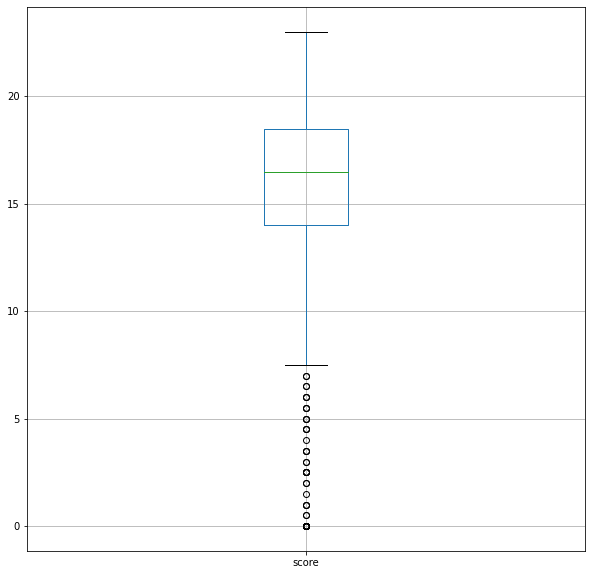

In [6]:
%matplotlib inline
# 横坐标为分数，纵坐标为箱线图 也就是分数分布
data.boxplot(column = 'score', figsize = (10, 10))

## 文本处理

In [7]:
example = "Dear Jerry I'm Li Hua. I know, you will to attend an English test. I think I can give you some advise. Such as, you should to know what you will to say. And when you say how you should to do. And you should to know how to leave. Yes, there are my advise. I think they are useful. And I think they can give you some help. So I say they in their. ' Yours, Li Hua"

### 替换缩写词

In [8]:
# 首先对句子做一个清洗，需要把缩写转换为原来的单词，如把I'm 转换成I am
def covert_abb2words(essay):
    #essay = essay.lower()
    essay = essay.replace("I'm","I am").replace("'ve"," have").replace("'ll"," will").replace("n't"," not")
    return essay
    
covert_abb2words(example)

"Dear Jerry I am Li Hua. I know, you will to attend an English test. I think I can give you some advise. Such as, you should to know what you will to say. And when you say how you should to do. And you should to know how to leave. Yes, there are my advise. I think they are useful. And I think they can give you some help. So I say they in their. ' Yours, Li Hua"

In [9]:
data["corrected"] = data.apply(lambda x : covert_abb2words(x["essay"]),axis=1)

In [10]:
data.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

                                           corrected  
0  Dear Jerry. I have heard about that you will g...  
1  Dear Jerry I am glad that you will respresent ...  
2  Dear Jerry, I am very happy to hear that you w...  
3  Dear Je I am so happy to hear that you will ha...  
4  Dear Jerry, I am so glad to hear that you will...

## 语义特征
这里我们还是使用之前google训练好的词向量

In [11]:
## 首先把essay转换成频率矩阵的形式
def get_count_vectors(essays):
    # 实例化vectorizer
    vectorizer = CountVectorizer(max_features=10000)
    #fit_transform(X)	拟合模型，并返回文本矩阵
    count_vectors = vectorizer.fit_transform(essays)
    # get_feature_names()	所有文本的词汇；列表型
    feature_names = vectorizer.get_feature_names()
    vocabulary = vectorizer.vocabulary_
    return feature_names, count_vectors,vocabulary

#返回essay的文章的文本矩阵和关键词列表
feature_names_cv,count_vectors,vocabulary = get_count_vectors(data["corrected"])

In [12]:
feature_names_cv

['00',
 '000',
 '100',
 '1000',
 '11',
 '12',
 '13407369803',
 '15',
 '17',
 '1863406',
 '19',
 '1989',
 '1x',
 '2000',
 '2018',
 '20th',
 '2333335',
 '2731',
 '286',
 '305',
 '3peach',
 '50',
 '5x',
 '60',
 '70',
 '7x',
 '832',
 '88888888',
 '99',
 '9n',
 'aad',
 'aadiences',
 'aaditionly',
 'aagin',
 'aback',
 'abad',
 'ability',
 'able',
 'ablitilys',
 'aboard',
 'aboat',
 'abody',
 'abont',
 'abord',
 'abou',
 'aboue',
 'aboul',
 'about',
 'above',
 'abroad',
 'abserve',
 'absorb',
 'absorbe',
 'absorbed',
 'absutly',
 'abtention',
 'abut',
 'acc',
 'acceessed',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accidents',
 'accomplish',
 'accopmplish',
 'according',
 'account',
 'accpect',
 'accpet',
 'accroding',
 'accross',
 'accter',
 'acepet',
 'acepted',
 'acheivement',
 'achevement',
 'achieve',
 'achievement',
 'achive',
 'aciationly',
 'acix',
 'ack',
 'acl',
 'acoiss',
 'across',
 'act',
 'acting',
 'action',
 'actioning',
 'actions',
 'actity',
 'active',
 'actively',


In [13]:
len(feature_names_cv)

5584

In [14]:
vocabulary

{'dear': 1286,
 'jerry': 2594,
 'have': 2228,
 'heard': 2240,
 'about': 47,
 'that': 5030,
 'you': 5535,
 'will': 5415,
 'give': 2085,
 'deliver': 1316,
 'to': 5129,
 'the': 5034,
 'students': 4799,
 'of': 3462,
 'senior': 4390,
 'one': 3485,
 'feel': 1787,
 'very': 5292,
 'proud': 3956,
 'here': 2280,
 'are': 376,
 'some': 4577,
 'tips': 5122,
 'for': 1920,
 'first': 1859,
 'and': 292,
 'foremost': 1924,
 'it': 2576,
 'importante': 2455,
 'know': 2644,
 'content': 1181,
 'speech': 4649,
 'well': 5367,
 'which': 5392,
 'help': 2264,
 'no': 3413,
 'nervous': 3382,
 'when': 5383,
 'giving': 2090,
 'furthermore': 2024,
 'pay': 3598,
 'body': 733,
 'languages': 2739,
 'should': 4466,
 'be': 578,
 'attached': 447,
 'ca': 820,
 'great': 2147,
 'importance': 2450,
 'while': 5394,
 'speaking': 4631,
 'attract': 500,
 'audience': 518,
 'last': 2805,
 'but': 813,
 'not': 3425,
 'least': 2918,
 'leave': 2925,
 'stage': 4715,
 'politely': 3765,
 'all': 247,
 'relaxed': 4109,
 'these': 5050,
 'days

In [15]:
len(vocabulary)

5584

In [16]:
'''
#把下载好的文件转换成dict的格式并保存至pickle，只挑选我们文章中有的词汇
from datetime import datetime
import pickle
t0 = datetime.now()
w_v = {}
with open("glove.6B.100d.txt",encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        word = line.split(" ")[0]
        if word in vocabulary.keys():
            v = line.split()[1:-1]
            w_v[word] = v
        
# def return_vector(essay):
#     {}
    
# lines[:10]
#print(w_v)
with open("glove_abb2word.6B.100d.pkl", "wb") as fp:   #Pickling
    pickle.dump(w_v, fp, protocol = pickle.HIGHEST_PROTOCOL)
#w_v.to_pickle('glove.6B.100d.pkl')
t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))
'''

'\n#把下载好的文件转换成dict的格式并保存至pickle，只挑选我们文章中有的词汇\nfrom datetime import datetime\nimport pickle\nt0 = datetime.now()\nw_v = {}\nwith open("glove.6B.100d.txt",encoding="utf-8") as f:\n    lines = f.readlines()\n    for line in lines:\n        word = line.split(" ")[0]\n        if word in vocabulary.keys():\n            v = line.split()[1:-1]\n            w_v[word] = v\n        \n# def return_vector(essay):\n#     {}\n    \n# lines[:10]\n#print(w_v)\nwith open("glove_abb2word.6B.100d.pkl", "wb") as fp:   #Pickling\n    pickle.dump(w_v, fp, protocol = pickle.HIGHEST_PROTOCOL)\n#w_v.to_pickle(\'glove.6B.100d.pkl\')\nt1 = datetime.now()\nprint(\'Processing time: {}\'.format(t1 - t0))\n'

In [17]:
#加载原来已经处理好的词汇向量文件，这个里面只保留了我们的文章里有的词汇
import pickle
with open("glove_abb2word.6B.100d.pkl", "rb") as fp:   #Pickling
    w_v_dict = pickle.load(fp)  

In [18]:
len(w_v_dict)

2832

In [19]:
# 输入文章，得出文章矩阵，如果文章中的词汇在这里，那么就返回词汇向量，如果没有就不就散了
def get_glove_100_vec(essay,w_v_dict):
    essay = essay.lower()
    essay_list = essay.split()     # 将句子(英文)通过空格分割成由单词组成的list
    essay_vec = []    # 存储向量的矩阵
    for e in essay_list:     # 遍历所有单词，返回每个单词的向量
        #e = word_del_punctuation(e)   # str处理，去除标点符号
        if e in w_v_dict:
            vector = [float(num) for num in w_v_dict[e]]
            essay_vec.append(vector)
        #else:
            #vector = np.zeros((1,100))
            #essay_vec.append(vector)
            #print(type(w_v_dict[e]))
    essay_vec = pd.DataFrame(essay_vec)  # 转成DataFrame格式，方便求句子的向量平均值
    if len(essay_list) > 0:
        return (essay_vec.sum() / len(essay_list)).tolist() # 这是一个essay地向量，总共有100维
    else:
        print('Error')

In [20]:
#测试词向量特征
example = "Dear Jerry I am Li Hua. I know, you will to attend an English test. I think I can give you some advise. Such as, you should to know what you will to say. And when you say how you should to do. And you should to know how to leave. Yes, there are my advise. I think they are useful. And I think they can give you some help. So I say they in their. ' Yours, Li Hua"
get_glove_100_vec(example,w_v_dict)

[-0.13553795750000003,
 0.2588367875,
 0.28515293750000004,
 -0.28514219412499997,
 -0.24403648875,
 0.1680435965,
 -0.21678215,
 0.17170942375,
 0.047616775000000014,
 -0.11989843750000002,
 0.09236617500000002,
 0.0744047625,
 0.25159748750000005,
 0.021821608749999985,
 0.010148949999999997,
 -0.29882947499999996,
 0.13542767749999998,
 0.22289398750000006,
 -0.52089635,
 0.3087066124999999,
 0.1637944475,
 -0.0014466249999999972,
 0.07201395,
 -0.08138825000000001,
 0.03843543749999998,
 0.0485547625,
 -0.10619462500000001,
 -0.46362687499999994,
 0.20303066250000001,
 -0.22164630000000002,
 -0.12076567499999999,
 0.5134347374999999,
 0.024856977500000002,
 0.056421475,
 0.05366742500000001,
 0.3002825375,
 0.009404434999999992,
 0.23738604000000002,
 0.07527945,
 -0.24039925,
 -0.33163774,
 -0.196838675,
 -0.055453365,
 -0.44615637500000005,
 -0.266930575,
 -0.017439337499999995,
 0.10234493999999998,
 -0.28087398750000003,
 -0.08144695500000002,
 -0.7269315,
 0.018454335,
 -0.050

In [21]:
#把essays转换为向量形式
vectors_glove = []
count = 1
for essay in data['essay']:
    vectors_glove.append(get_glove_100_vec(essay,w_v_dict))
    print("已处理{}篇".format(count))
    count+=1

已处理1篇
已处理2篇
已处理3篇
已处理4篇
已处理5篇
已处理6篇
已处理7篇
已处理8篇
已处理9篇
已处理10篇
已处理11篇
已处理12篇
已处理13篇
已处理14篇
已处理15篇
已处理16篇
已处理17篇
已处理18篇
已处理19篇
已处理20篇
已处理21篇
已处理22篇
已处理23篇
已处理24篇
已处理25篇
已处理26篇
已处理27篇
已处理28篇
已处理29篇
已处理30篇
已处理31篇
已处理32篇
已处理33篇
已处理34篇
已处理35篇
已处理36篇
已处理37篇
已处理38篇
已处理39篇
已处理40篇
已处理41篇
已处理42篇
已处理43篇
已处理44篇
已处理45篇
已处理46篇
已处理47篇
已处理48篇
已处理49篇
已处理50篇
已处理51篇
已处理52篇
已处理53篇
已处理54篇
已处理55篇
已处理56篇
已处理57篇
已处理58篇
已处理59篇
已处理60篇
已处理61篇
已处理62篇
已处理63篇
已处理64篇
已处理65篇
已处理66篇
已处理67篇
已处理68篇
已处理69篇
已处理70篇
已处理71篇
已处理72篇
已处理73篇
已处理74篇
已处理75篇
已处理76篇
已处理77篇
已处理78篇
已处理79篇
已处理80篇
已处理81篇
已处理82篇
已处理83篇
已处理84篇
已处理85篇
已处理86篇
已处理87篇
已处理88篇
已处理89篇
已处理90篇
已处理91篇
已处理92篇
已处理93篇
已处理94篇
已处理95篇
已处理96篇
已处理97篇
已处理98篇
已处理99篇
已处理100篇
已处理101篇
已处理102篇
已处理103篇
已处理104篇
已处理105篇
已处理106篇
已处理107篇
已处理108篇
已处理109篇
已处理110篇
已处理111篇
已处理112篇
已处理113篇
已处理114篇
已处理115篇
已处理116篇
已处理117篇
已处理118篇
已处理119篇
已处理120篇
已处理121篇
已处理122篇
已处理123篇
已处理124篇
已处理125篇
已处理126篇
已处理127篇
已处理128篇
已处理129篇
已处理130篇
已处理131篇
已处理132篇
已处理133篇
已处理134篇
已处理135篇
已处理136篇
已处理137篇
已处理138篇
已处理1

In [22]:
# 把列表转换成数据框格式
vectors_glove = pd.DataFrame(vectors_glove)

In [23]:
print(vectors_glove.shape)
vectors_glove.head()

(1001, 99)


0         1         2         3         4         5         6   \
0 -0.120686  0.155074  0.315100 -0.182956 -0.124893  0.150174 -0.212914   
1 -0.096388  0.185211  0.360958 -0.184626 -0.109197  0.223573 -0.219939   
2 -0.165218  0.230092  0.394004 -0.241641 -0.204977  0.202470 -0.191531   
3 -0.136330  0.210490  0.333176 -0.254893 -0.124894  0.221892 -0.190266   
4 -0.163342  0.222142  0.335085 -0.222246 -0.085029  0.207153 -0.201252   

         7         8         9   ...        89        90        91        92  \
0  0.159672 -0.047339 -0.092322  ... -0.268447 -0.054396 -0.096545  0.011370   
1  0.106561 -0.119904 -0.026553  ... -0.264193 -0.047806 -0.121456 -0.028583   
2  0.184408 -0.026965 -0.111635  ... -0.296409 -0.103088 -0.031124  0.031590   
3  0.179672 -0.043548 -0.108977  ... -0.262332 -0.084266 -0.085750  0.037456   
4  0.153767 -0.038588 -0.051452  ... -0.249985 -0.054179 -0.057925 -0.027644   

         93        94        95        96        97        98  
0 -0.016519 -0.408406 -0.048633 -0.170380 -0.307924  0.344400  
1 -0.007365 -0.416639 -0.121725 -0.118571 -0.277530  0.402811  
2  0.023312 -0.436750 -0.060165 -0.094003 -0.325644  0.377455  
3 -0.034176 -0.439657 -0.064015 -0.064168 -0.287647  0.386404  
4 -0.014042 -0.426040 -0.084366 -0.170212 -0.345353  0.434815  

[5 rows x 99 columns]

In [25]:
vectors_glove.isnull().sum()

0     0
1     0
2     0
3     0
4     0
     ..
94    0
95    0
96    0
97    0
98    0
Length: 99, dtype: int64

## 添加其他特征

In [26]:
# 返回总的单词列表
def sentence_to_wordlist(raw_sentence):
    #句子清洗
    # re的用法：replacedStr = re.sub("\d+", "222", inputStr)
    clean_sentence = re.sub("[^a-zA-Z0-9]", " ", raw_sentence)# 这里主要是去除除了a-zA-Z0-9之外的字符
    #nltk 分词
    tokens = nltk.word_tokenize(clean_sentence)
    #返回分词的结果
    return tokens

In [28]:
sentence_to_wordlist(example)

['Dear',
 'Jerry',
 'I',
 'am',
 'Li',
 'Hua',
 'I',
 'know',
 'you',
 'will',
 'to',
 'attend',
 'an',
 'English',
 'test',
 'I',
 'think',
 'I',
 'can',
 'give',
 'you',
 'some',
 'advise',
 'Such',
 'as',
 'you',
 'should',
 'to',
 'know',
 'what',
 'you',
 'will',
 'to',
 'say',
 'And',
 'when',
 'you',
 'say',
 'how',
 'you',
 'should',
 'to',
 'do',
 'And',
 'you',
 'should',
 'to',
 'know',
 'how',
 'to',
 'leave',
 'Yes',
 'there',
 'are',
 'my',
 'advise',
 'I',
 'think',
 'they',
 'are',
 'useful',
 'And',
 'I',
 'think',
 'they',
 'can',
 'give',
 'you',
 'some',
 'help',
 'So',
 'I',
 'say',
 'they',
 'in',
 'their',
 'Yours',
 'Li',
 'Hua']

In [29]:
# 把每个句子都拆成单词列表
def tokenize(essay):
    # 去掉句子前后空格
    stripped_essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay) # 分句
    #print(raw_sentences)
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    return tokenized_sentences

In [30]:
tokenize(example)

[['Dear', 'Jerry', 'I', 'am', 'Li', 'Hua'],
 ['I', 'know', 'you', 'will', 'to', 'attend', 'an', 'English', 'test'],
 ['I', 'think', 'I', 'can', 'give', 'you', 'some', 'advise'],
 ['Such',
  'as',
  'you',
  'should',
  'to',
  'know',
  'what',
  'you',
  'will',
  'to',
  'say'],
 ['And', 'when', 'you', 'say', 'how', 'you', 'should', 'to', 'do'],
 ['And', 'you', 'should', 'to', 'know', 'how', 'to', 'leave'],
 ['Yes', 'there', 'are', 'my', 'advise'],
 ['I', 'think', 'they', 'are', 'useful'],
 ['And', 'I', 'think', 'they', 'can', 'give', 'you', 'some', 'help'],
 ['So', 'I', 'say', 'they', 'in', 'their'],
 ['Yours', 'Li', 'Hua']]

In [31]:
# 平均词数
def avg_word_len(essay):
    # 清洗文章
    clean_essay = re.sub(r'\W', ' ', essay)
    # 分词
    words = nltk.word_tokenize(clean_essay)
    # 遍历word，然后把每一个word的单词数目相加，然后除以总的单词数目，即可得到 每个单词平均有几个字母
    return sum(len(word) for word in words) / len(words)

In [32]:
avg_word_len(example)

3.3797468354430378

In [33]:
def word_count(essay):
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    return len(words)

In [34]:
def char_count(essay):
    # 删除空格即返回文章字母总数
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    return len(clean_essay)

In [35]:
def sent_count(essay):
    sentences = nltk.sent_tokenize(essay)
    return len(sentences)

In [36]:
# 提取出所有的名词 形容词 动词 副词
def count_lemmas(essay):
    #分句
    tokenized_sentences = tokenize(essay)
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()

    for sentence in tokenized_sentences:
        # 给句子标注词性
        tagged_tokens = nltk.pos_tag(sentence)
        for token_tuple in tagged_tokens:
            # 取第一个，即为该单词词性
            pos_tag = token_tuple[1]
            if pos_tag.startswith('N'):
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
                
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    lemma_count = len(set(lemmas))
    # print(lemma_count)
    return lemma_count

In [37]:
count_lemmas(example)

39

In [38]:
# 测试nltk中的lemma使用
'''
def count_lemmas(essay):
    #分句
    tokenized_sentences = tokenize(essay)
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()

    for sentence in tokenized_sentences:
        # 给句子标注词性
        tagged_tokens = nltk.pos_tag(sentence)
       # print(tagged_tokens)
        for token_tuple in tagged_tokens:
            # 取第二个，即为该单词词性
            pos_tag = token_tuple[1]
            if pos_tag.startswith('N'):
                pos = wordnet.NOUN
                # 这里是提取了所有名词
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
 #           print(lemmas)
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
           # print(lemmas)
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
count_lemmas(example)
'''

"\ndef count_lemmas(essay):\n    #分句\n    tokenized_sentences = tokenize(essay)\n    lemmas = []\n    wordnet_lemmatizer = WordNetLemmatizer()\n\n    for sentence in tokenized_sentences:\n        # 给句子标注词性\n        tagged_tokens = nltk.pos_tag(sentence)\n       # print(tagged_tokens)\n        for token_tuple in tagged_tokens:\n            # 取第二个，即为该单词词性\n            pos_tag = token_tuple[1]\n            if pos_tag.startswith('N'):\n                pos = wordnet.NOUN\n                # 这里是提取了所有名词\n                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))\n #           print(lemmas)\n            elif pos_tag.startswith('J'):\n                pos = wordnet.ADJ\n                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))\n           # print(lemmas)\n            elif pos_tag.startswith('V'):\n                pos = wordnet.VERB\n                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))\n            elif pos_tag.startswith('R'

In [39]:
# 这里需要定制化一下，加入li 和hua 这两个词
def count_spell_error(essay):
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)

    # big.txt: It is a concatenation of public domain book excerpts from Project Gutenberg
    #         and lists of most frequent words from Wiktionary and the British National Corpus.
    #         It contains about a million words.
    data = open('big.txt').read()

    words_ = re.findall('[a-z]+', data.lower())


    word_dict = collections.defaultdict(lambda: 0)

    for word in words_:
        word_dict[word] += 1

    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)

    mispell_count = 0
    mispell_words = []

    words = clean_essay.split()

    for word in words:
        # 针对该文本的特殊词汇
        if word not in ["li","hua","jerry"]:
            # 如果essay中的词汇不在big data 这个文件下，那么就认为这个单词拼写错了
            if not word in word_dict:
                mispell_count += 1
                mispell_words.append(word)

    return mispell_count

In [40]:
count_spell_error(example)

0

In [41]:
def count_pos(essay):
    tokenized_sentences = tokenize(essay)

    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)

        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]

            if pos_tag.startswith('N'):
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1

    return noun_count, adj_count, verb_count, adv_count

In [42]:
# 连词与介词
def count_conj(essay):
    tokenized_sentences = tokenize(essay)

    conj_count = 0
    ps_conj = 0
    conjs = []
    ps = []

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)

        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
            
            if pos_tag.startswith('CC'):
                conj_count += 1
               # conjs.append(token_tuple[0])
            if pos_tag.startswith("IN"):
                ps_conj += 1
               # ps.append(token_tuple[0])
    return conj_count,ps_conj

In [43]:
count_conj(example)

(3, 3)

In [44]:
# 使用spacy获取命名实体识别特征
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from datetime import datetime
ner = []

stop_words = set(STOP_WORDS)
#stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_md')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

# 遍历所有的文章，找出其中的 token，句子，词性标注，命名实体识别和lemma
#for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_threads=3):
for essay in nlp.pipe(data['corrected'], batch_size=100):
    if essay.is_parsed:
        ner.append([e.text for e in essay.ents])
        #ner_num = len(ner)
    else:
        # 让所有的元素都有相同的长度，所以在没有的地方加none
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        ner.append(None)
        #ner_num = len(ner)


data['ner'] = ner
data["ner_num"] = data.apply(lambda x:len(x['ner']),axis=1)
#print(data['ner'])
data.drop ('ner',axis=1, inplace=True) 
t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

D:\Program\anaconda\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_md' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Processing time: 0:00:29.017360


In [46]:
# 判断写作的正确结尾：因为这是信件，所以我们就以是否以lihua结尾来判断
def End0(essay):
    try:
        if essay.endswith('Li Hua'):
            return 1

        else:
            return 0 
    except:
        return -1
# 之后需要把end0 这一列转换成one-hot编码

In [47]:
End0(example)

1

In [48]:
# 判断句中首字母是否大写，“.？！”后接大写，“，”后字母接小写。 
def Initial_capitalization(text):
    c = 0 # c指错误
    text = text.replace(' ','')
    try:
        if not text.startswith("Dear J"):
            c += 1
        for i in range(len(text)-1):
            if text[i] in  ".!?" and text[i+1].islower():
                c += 1
            if text[i] in  "," and not text[i+1].islower():
                c += 1 
    except Exception as e:
        pass
    return c

In [49]:
# 统计错误标点使用
def Wrong_signal(line):
    return len(re.findall(r'[，。!！~·@#￥%……&*（）——+|《》？`$()_\、“”："><]', line))

In [52]:
data.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

                                           corrected  ner_num  
0  Dear Jerry. I have heard about that you will g...        3  
1  Dear Jerry I am glad that you will respresent ...        5  
2  Dear Jerry, I am very happy to hear that you w...        5  
3  Dear Je I am so happy to hear that you will ha...        3  
4  Dear Jerry, I am so glad to hear that you will...        4

In [53]:
def extract_features(data):
    features = data.copy()
    features['char_count'] = features['corrected'].apply(char_count) #文章字母总数
    #features['word_count'] = features['corrected'].apply(word_count) #文章单词总数
    features['sent_count'] = features['corrected'].apply(sent_count) #文章句子总数
    features['avg_word_len'] = features['corrected'].apply(avg_word_len) #平均单词长度
    features['lemma_count'] = features['corrected'].apply(count_lemmas) # 文章词性统计
    features['spell_err_count'] = features['corrected'].apply(count_spell_error) # 文章写错的单词总数
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'] = zip(
        *features['corrected'].map(count_pos)) # 文章名词  动词 形容词 副词的总数
    features["conj"], features["ps_conj"] = zip(*features["corrected"].map(count_conj)) #连词的总数
    features['end'] = features.corrected.apply(End0)# 是否写完
    features['captilization'] = features.corrected.apply(Initial_capitalization) # 首字母是否大写
    features['wrong_signal'] = features.corrected.apply(Wrong_signal) # 是否有错误的字符
    features['comma'] = features.apply(lambda x: x['corrected'].count(','), axis=1) 
    features['question'] = features.apply(lambda x: x['corrected'].count('?'), axis=1)
    features['exclamation'] = features.apply(lambda x: x['corrected'].count('!'), axis=1)
    features['quotation'] = features.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
    return features


In [171]:
#拿到特征
features = extract_features(data)
#print(features.columns)

In [54]:
features.to_pickle('features_v3.pkl')

NameError: name 'features' is not defined

In [42]:
features = pd.read_pickle("features_v3.pkl")

In [43]:
features.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

                                           corrected  ner_num  char_count  \
0  Dear Jerry. I have heard about that you will g...        3         514   
1  Dear Jerry I am glad that you will respresent ...        5         618   
2  Dear Jerry, I am very happy to hear that you w...        5         676   
3  Dear Je I am so happy to hear that you will ha...        3         555   
4  Dear Jerry, I am so glad to hear that you will...        4         657   

   sent_count  avg_word_len  lemma_count  spell_err_count  ...  adv_count  \
0          15      4.142857           85                3  ...         11   
1          11      4.357664           85                5  ...         10   
2          18      3.975610           92                2  ...         12   
3          14      4.092308           78                6  ...         14   
4          11      4.260000           87               13  ...         14   

   conj  ps_conj  end  captilization  wrong_signal  comma  question  \
0     2        8    1              3             0      5         0   
1     3       14    0              1             1      5         0   
2     7       15    1              3             4      5         0   
3     3        8    1              3             0      7         0   
4     5       12    1              3             0      8         1   

   exclamation  quotation  
0            0          2  
1            0          3  
2            4          0  
3            0          3  
4            0          0  

[5 rows x 23 columns]

### 把END 特征转换成one-hot

In [44]:
from sklearn.preprocessing import OneHotEncoder
tempdata = features[['end']]
#print(tempdata)
enc = OneHotEncoder()
enc.fit(tempdata)

#one-hot编码的结果是比较奇怪的，最好是先转换成二维数组
tempdata = enc.transform(tempdata).toarray()
#print(tempdata)
end = pd.DataFrame(tempdata)

In [45]:
# 最后得到一个数据框，但是为了保留列名，所以我们增加end的列名
features["end1"],features["end2"] = end

In [46]:
features.drop(["end"],axis=1)
features = pd.DataFrame(features)

In [47]:
features.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

                                           corrected  ner_num  char_count  \
0  Dear Jerry. I have heard about that you will g...        3         514   
1  Dear Jerry I am glad that you will respresent ...        5         618   
2  Dear Jerry, I am very happy to hear that you w...        5         676   
3  Dear Je I am so happy to hear that you will ha...        3         555   
4  Dear Jerry, I am so glad to hear that you will...        4         657   

   sent_count  avg_word_len  lemma_count  spell_err_count  ...  ps_conj  end  \
0          15      4.142857           85                3  ...        8    1   
1          11      4.357664           85                5  ...       14    0   
2          18      3.975610           92                2  ...       15    1   
3          14      4.092308           78                6  ...        8    1   
4          11      4.260000           87               13  ...       12    1   

   captilization  wrong_signal  comma  question  exclamation  quotation  end1  \
0              3             0      5         0            0          2     0   
1              1             1      5         0            0          3     0   
2              3             4      5         0            4          0     0   
3              3             0      7         0            0          3     0   
4              3             0      8         1            0          0     0   

   end2  
0     1  
1     1  
2     1  
3     1  
4     1  

[5 rows x 25 columns]

In [48]:
##添加wordcount特征
features["word_count"] = features['corrected'].str.strip().str.split().str.len()

### 提取句子语法特征-这种方法不行，先舍弃吧

In [49]:
from tqdm import tqdm
with open("homes_novel.txt") as f:
    collocation = []
    for line in tqdm(f.readlines()):
        txt = line.replace("\n","").replace("\t","")
        tokenized_sentences = tokenize(txt)
        wordnet_lemmatizer = WordNetLemmatizer()
        for sentence in tokenized_sentences:
            pos_tags = []
        # 给句子标注词性
            tagged_tokens = nltk.pos_tag(sentence)
            #print(tagged_tokens)
            for token_tuple in tagged_tokens:
                # 取第二个，即为该单词词性
                pos_tag = token_tuple[1]
                pos_tags.append(pos_tag) 
            #print(pos_tags)
            cos = [*nltk.ngrams(pos_tags, 4)] # 取四元词组,结构[(4-gram),(4-gram),(4-gram)]
            for co in cos:
                if co not in collocation:
                    collocation.append(co)
                    #print(co)
    #print(collocation)

  0%|                                                           | 0/121649 [00:00<?, ?it/s]


NameError: name 'tokenize' is not defined

In [50]:
'''
# 把提取好的搭配列表放在pickle中
with open("collocations.pkl", "wb") as fp:   #Pickling
    pickle.dump(collocation, fp, protocol = pickle.HIGHEST_PROTOCOL)
'''

'\n# 把提取好的搭配列表放在pickle中\nwith open("collocations.pkl", "wb") as fp:   #Pickling\n    pickle.dump(collocation, fp, protocol = pickle.HIGHEST_PROTOCOL)\n'

In [51]:
len(collocation)

0

In [52]:
example = "I Dear Jerry, I'm glad that you'll have an English speech contest for these students which are new in high school. I have something you need to ( Yemember ) pay attentions. For a speech contest, the basic thing is knowing what you want to make others understand, and remember what you will told them. From the message you give me, I have some ( su ) ideas that you may need. The topic of you speech is about chinese culture, and I think the Ancient poetry is a good choice for you. If you using some good poems ( o ) in you speech, it wowld be ( fa ) great, and it can make your speech topic more deepey. Body languages are also very important for a speech contest. Sometimes the uses of body languages can make you speech(more)interesting,and others can understand your speech easily by this way. so, remember to use some body languages, but don't need too much, just three to five in you speech. After you speech end, you should follow the manners, politely out from the speech place. I'm looking forward to your good news. Yours. ! Li Hua"

In [75]:
# 计算某个文本中搭配正确的比例,主要采用的四元词汇,效果不好，因为有的确实语法上是错误的，但是词性上没有错误
def count_pos_right(essay):
    with open("collocations.pkl", "rb") as fp:   #Pickling
        r_collocation = pickle.load(fp)  
    e_collocation = []
    c = 0
    tokenized_sentences = tokenize(essay)
    for sentence in tokenized_sentences:
        pos_tags = []
        tagged_tokens = nltk.pos_tag(sentence)
        for token_tuple in tagged_tokens:
                # 取第二个，即为该单词词性
            pos_tag = token_tuple[1]
            pos_tags.append(pos_tag)
        cos = [*nltk.ngrams(pos_tags, 4)] # 取四元词组
        for co in cos:
            #print(co)
            if co not in e_collocation:
                e_collocation.append(co)
    #print(e_collocation)
    #print(len(e_collocation))
    for coll in e_collocation:
        if r_collocation.index(coll):
            c+=1 
    r_p = c/len(e_collocation)
    print(r_p)
    return r_p          

In [76]:
# 测试
count_pos_right(example)

ValueError: ('NN', 'VBZ', 'VBG', 'WP') is not in list

In [73]:
features.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

                                           corrected  ner_num  char_count  \
0  Dear Jerry. I have heard about that you will g...        3         514   
1  Dear Jerry I am glad that you will respresent ...        5         618   
2  Dear Jerry, I am very happy to hear that you w...        5         676   
3  Dear Je I am so happy to hear that you will ha...        3         555   
4  Dear Jerry, I am so glad to hear that you will...        4         657   

   sent_count  avg_word_len  lemma_count  spell_err_count  ...  ps_conj  end  \
0          15      4.142857           85                3  ...        8    1   
1          11      4.357664           85                5  ...       14    0   
2          18      3.975610           92                2  ...       15    1   
3          14      4.092308           78                6  ...        8    1   
4          11      4.260000           87               13  ...       12    1   

   captilization  wrong_signal  comma  question  exclamation  quotation  end1  \
0              3             0      5         0            0          2     0   
1              1             1      5         0            0          3     0   
2              3             4      5         0            4          0     0   
3              3             0      7         0            0          3     0   
4              3             0      8         1            0          0     0   

   end2  
0     1  
1     1  
2     1  
3     1  
4     1  

[5 rows x 25 columns]

In [74]:
features["pos_checker"] = features.apply(lambda x:count_pos_right(x["corrected"]),axis=1)

ValueError: ('NN', 'RB', 'RB', 'WDT') is not in list

In [53]:
features.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

                                           corrected  ner_num  char_count  \
0  Dear Jerry. I have heard about that you will g...        3         514   
1  Dear Jerry I am glad that you will respresent ...        5         618   
2  Dear Jerry, I am very happy to hear that you w...        5         676   
3  Dear Je I am so happy to hear that you will ha...        3         555   
4  Dear Jerry, I am so glad to hear that you will...        4         657   

   sent_count  avg_word_len  lemma_count  spell_err_count  ...  end  \
0          15      4.142857           85                3  ...    1   
1          11      4.357664           85                5  ...    0   
2          18      3.975610           92                2  ...    1   
3          14      4.092308           78                6  ...    1   
4          11      4.260000           87               13  ...    1   

   captilization  wrong_signal  comma  question  exclamation  quotation  end1  \
0              3             0      5         0            0          2     0   
1              1             1      5         0            0          3     0   
2              3             4      5         0            4          0     0   
3              3             0      7         0            0          3     0   
4              3             0      8         1            0          0     0   

   end2  word_count  
0     1         117  
1     1         132  
2     1         167  
3     1         127  
4     1         150  

[5 rows x 26 columns]

In [35]:
from spacy.lang.en.stop_words import STOP_WORDS

## 探索主题个数

In [333]:
import nltk.tokenize as tk
import nltk.corpus as nc
import nltk.stem.snowball as sb
import gensim.models.ldamodel as gm
import gensim.corpora as gc

#读取数据和停用词
tokenizer = tk.WordPunctTokenizer() 

signs = [',', '.', '!',"’"]
stopwords = STOP_WORDS
'''
SnowballStemmer基于Snowball 词干提取算法，该算法使用RegexpStemmer 类构建词干提取器，通过接收一个字符串，并在找到其匹配的单词时删除该单词的前缀或后缀。示例如图三。

'''

# stem a word 都是英文
stemmer = sb.SnowballStemmer('english')

tokenized_sentences = tokenize(example)

lines_tokens = []
for line in tokenized_sentences: # 读取每一个句子
    # 变小写
    line_tokens = []
    for token in line:
        token = token.lower()
        # 取出停用词和标点符号
        if token not in stopwords and token not in signs:
            # 取出所有单词的单词原型
            token = stemmer.stem(token)
            #print(token)
          # 把token加在句子列表里
            line_tokens.append(token)
            #print(line_tokens)
# 再把句子列表加入文文章列表中
    lines_tokens.append(line_tokens)
#print(lines_tokens)

# # 把lines_tokens中出现的单词都存入gc提供的词典对象，对每一个单词做编码。
dic = gc.Dictionary(lines_tokens)

# # 遍历每一行，构建词袋列表
corpus = []
for line_tokens in lines_tokens:
    row = dic.doc2bow(line_tokens)
    corpus.append(row)

n_topics = 1
# # passes：训练伦次
model = gm.LdaModel(corpus, num_topics=n_topics, id2word=dic, passes=50)

# # 输出每个类别中对类别贡献最大的4个主题词
topics = model.print_topics(num_topics=n_topics, num_words=20)
print(topics)

[(0, '0.084*"speech" + 0.028*"bodi" + 0.028*"good" + 0.028*"contest" + 0.028*"need" + 0.028*"languag" + 0.021*"use" + 0.021*"understand" + 0.021*"rememb" + 0.021*"m" + 0.021*"topic" + 0.014*"don" + 0.014*"import" + 0.014*"poem" + 0.014*"o" + 0.014*"great" + 0.014*"fa" + 0.014*"easili" + 0.014*"wowld" + 0.014*"interest"')]


In [54]:
features.columns

Index(['id', 'essay', 'score', 'corrected', 'ner_num', 'char_count',
       'sent_count', 'avg_word_len', 'lemma_count', 'spell_err_count',
       'noun_count', 'adj_count', 'verb_count', 'adv_count', 'conj', 'ps_conj',
       'end', 'captilization', 'wrong_signal', 'comma', 'question',
       'exclamation', 'quotation', 'end1', 'end2', 'word_count'],
      dtype='object')

In [55]:
features["word_count"] = features['corrected'].str.strip().str.split().str.len()

In [56]:
n = len(features['char_count'] )
scores = features["score"]
char_count = features['char_count'].corr(scores,method="spearman")
word_count = features['word_count'].corr(scores,method="spearman")
sent_count = features['sent_count'].corr(scores,method="spearman")
avg_word_len = features['avg_word_len'].corr(scores,method="spearman")
lemma_count = features['lemma_count'].corr(scores,method="spearman")
spell_err_count = features['spell_err_count'].corr(scores,method="spearman")
noun_count =  features['noun_count'].corr(scores,method="spearman")
adj_count = features['adj_count'].corr(scores,method="spearman")
verb_count = features['verb_count'].corr(scores,method="spearman")
adv_count = features['adv_count'].corr(scores,method="spearman")
conj_count =  features["conj"].corr(scores,method="spearman")
ps_conj_count = features["ps_conj"].corr(scores,method="spearman")
ner_num = features['ner_num'].corr(scores,method='spearman')
end = features['end'].corr(scores,method='spearman')
captilization = features['captilization'].corr(scores,method='spearman')
wrong_signal = features['wrong_signal'].corr(scores,method='spearman')
comma = features['comma'].corr(scores,method='spearman')
question = features['question'].corr(scores,method='spearman')
exclamation = features['exclamation'].corr(scores,method='spearman')
quotation = features['quotation'].corr(scores,method='spearman')

In [38]:
# 封装成字典并按照value 排序
spearman_dic = {
    "char_count":char_count
    ,"word_count":word_count
    ,"sent_count":sent_count
    ,"avg_word_len":avg_word_len
    ,"lemma_count":lemma_count
    ,"spell_err_count":spell_err_count
    ,"noun_count":noun_count
    ,"adj_count":adj_count
    ,"verb_count":verb_count
    ,"adv_count":adv_count
    ,"conj_count":conj_count
    ,"ps_conj_count":ps_conj_count
    ,"ner_num":ner_num
    ,'end':end
    ,'captilization':captilization
    ,'wrong_signal':wrong_signal
    ,'comma':comma
    ,'exclamation':exclamation
    ,'quotation':quotation
    ,'question':question
}
a = sorted(spearman_dic.items(), key=lambda x: x[1], reverse=True)
for item in a:
    print(item)
# 排序可知,词汇丰富度/作文长度 对作文评分影响最重要，其次是形容词、名词、连词与动词的使用。

('lemma_count', 0.5888752645740568)
('char_count', 0.5611218563285321)
('word_count', 0.5104161931474022)
('adj_count', 0.4767567826267371)
('noun_count', 0.4573249706695252)
('ps_conj_count', 0.42377699701040883)
('verb_count', 0.4093593909755708)
('adv_count', 0.39983677073688506)
('conj_count', 0.35533381786205975)
('comma', 0.2664863575774475)
('sent_count', 0.26635519193646884)
('quotation', 0.22950912899552944)
('avg_word_len', 0.2291145126534697)
('wrong_signal', 0.19196122183933934)
('exclamation', 0.18424955976920795)
('ner_num', 0.12376759178641569)
('spell_err_count', 0.1134584987493702)
('question', 0.07628699241691425)
('end', -0.027325870170952324)
('captilization', -0.0927542127929696)


In [59]:
# 保留所有变量
input_features = features.drop(["essay","id","corrected"],axis=1)

## 数据标准化

In [60]:
from sklearn.preprocessing import StandardScaler
X = input_features.iloc[:,1:].values
y = input_features["score"].values
scaler = StandardScaler() #实例化
scaler.fit(X) #fit，本质是生成均值和方差
scaler.mean_ #查看均值的属性mean_
scaler.var_ #查看方差的属性var_

array([4.20690997e+00, 2.71917217e+04, 2.43952192e+01, 5.01983620e-02,
       4.50743087e+02, 1.64848398e+01, 5.93768170e+01, 1.90095060e+01,
       7.54390844e+01, 1.46627758e+01, 3.98924752e+00, 1.78608504e+01,
       1.17405072e-01, 8.98128245e+00, 5.28460151e+00, 1.32950805e+01,
       2.22203371e-01, 1.01453392e+00, 1.19072137e+00, 0.00000000e+00,
       0.00000000e+00, 1.47498754e+03])

In [61]:
X_new = scaler.fit_transform(X) #使用fit_transform(data)一步达成结果
#scaler.inverse_transform(x_std) #使用inverse_transform逆转标准化

In [62]:
X_new

array([[-0.77248045, -0.07675809,  0.57644572, ...,  0.        ,
         0.        , -0.13586005],
       [ 0.20261782,  0.55393051, -0.23340995, ...,  0.        ,
         0.        ,  0.25470833],
       [ 0.20261782,  0.9056607 ,  1.18383748, ...,  0.        ,
         0.        ,  1.16603456],
       ...,
       [-1.74757872, -3.06646466, -2.25804914, ...,  0.        ,
         0.        , -3.05210398],
       [-1.74757872, -3.06646466, -2.25804914, ...,  0.        ,
         0.        , -3.05210398],
       [-1.74757872, -3.06646466, -2.25804914, ...,  0.        ,
         0.        , -3.05210398]])

## 构建新的特征矩阵

In [63]:
#X = np.concatenate((X_new, vectors), axis = 1)
X = np.concatenate((X_new, vectors_glove), axis = 1)
y = y

In [64]:
# 检查是否有空值
pd.DataFrame(X).isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
116    0
117    0
118    0
119    0
120    0
Length: 121, dtype: int64

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [66]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)
for i in range(len(y_test)):
    print("预测分数：{}".format(y_pred[i]),"实际分数：{}".format(y_test[i]))
# The coefficients 表示每一个特征所占的权重
print("测试集得分：\n",linear_regressor.score(X_test,y_test))
print('LinearRegression Coefficients: \n', linear_regressor.coef_)
# The mean squared error
print("LinearRegression Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# 平均绝对百分比误差（Mean Absolute Percentage Error）
#print('LinearRegression MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print("R2:%f"% r2_score(y_test, y_pred))
print('-' * 50)

预测分数：14.668328846564158 实际分数：16.0
预测分数：12.863868776213769 实际分数：14.5
预测分数：10.91123019751493 实际分数：9.0
预测分数：19.65489933286471 实际分数：21.0
预测分数：15.423629523056333 实际分数：16.5
预测分数：17.789893592070822 实际分数：14.5
预测分数：15.232634170723303 实际分数：18.0
预测分数：14.699263256059714 实际分数：16.0
预测分数：16.57006690343607 实际分数：15.5
预测分数：16.351112748223294 实际分数：18.5
预测分数：13.261341684774578 实际分数：18.0
预测分数：17.121840450385278 实际分数：16.5
预测分数：17.04166698654973 实际分数：17.5
预测分数：16.267927060204173 实际分数：14.0
预测分数：13.712298722240504 实际分数：8.5
预测分数：15.812553905033969 实际分数：17.0
预测分数：18.777631244193827 实际分数：17.0
预测分数：12.612646713830705 实际分数：7.0
预测分数：14.83158247164531 实际分数：13.0
预测分数：-0.21781665189276467 实际分数：0.0
预测分数：16.904984878439834 实际分数：18.0
预测分数：17.06586136691577 实际分数：15.0
预测分数：14.922132625566977 实际分数：15.0
预测分数：16.33388032572877 实际分数：18.5
预测分数：16.85382075781215 实际分数：19.0
预测分数：11.036784108575533 实际分数：11.0
预测分数：17.3810219596316 实际分数：17.5
预测分数：-0.21781665189276467 实际分数：0.0
预测分数：20.38230620547923 实际分数：19.5
预测分数：13.489263910625425 实际

In [67]:
from sklearn.metrics import classification_report
alpha = 200
ridge = Ridge(alpha=alpha)# 正则项的程度
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print("测试集得分：\n {0}".format(ridge.score(X_test,y_test)))
#print('Ridge Coefficients: \n', ridge.coef_)
print("Ridge Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R2:%f"% r2_score(y_test, y_pred))
#print('Ridge MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))

print(classification_report(np.rint(y_pred), np.rint(y_test)))
print('-' * 50)

# 最佳：
'''
测试集得分：
 0.6781095758903712
Ridge Mean squared error: 7.86
R2:0.678110
'''

测试集得分：
 0.6833515542426993
Ridge Mean squared error: 7.04
R2:0.683352
              precision    recall  f1-score   support

         0.0       0.07      1.00      0.13         1
         1.0       0.00      0.00      0.00         9
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         5
        11.0       0.00      0.00      0.00         7
        12.0       0.38      0.25      0.30        12
        13.0       0.25      0.15      0.19        13
        14.0       0.12      0.14      0.13        29
        15.0       0.20      0.07      0.11        56
        16.

D:\Program\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245:

'\n测试集得分：\n 0.6781095758903712\nRidge Mean squared error: 7.86\nR2:0.678110\n'

In [68]:
ridge_ = Ridge()
# 网格搜索  找到最佳的alpha值，也就是最佳的正则项系数
param_alpha = {'alpha': range(10,60,1)}
#传入模型和参数
grid = GridSearchCV(estimator=ridge_, param_grid=param_alpha) # 网格搜索同时满足了fit，search 和score 的三种功能
# 网格搜索会从参数中不断选取对应的参数进行组合，然后自动进行交叉验证，返回每一组参数下交叉验证的
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
#输出最佳结果
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

print("测试集最佳得分：\n",grid.best_score_)
print("Grid Ridge Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#print('Grid Ridge MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('-' * 50)

0.7003799516330043
Ridge(alpha=10)
{'alpha': 10}
测试集最佳得分：
 0.7003799516330043
Grid Ridge Mean squared error: 6.54
--------------------------------------------------


In [69]:
%%time
rf = ensemble.RandomForestRegressor()
params = {'n_estimators': range(50,70,1), 'max_depth':[10, 50, 100], 'max_features':[2, 5, 10]}
grid = GridSearchCV(estimator=rf, param_grid=params)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

for i in range(len(y_test)):
    print("预测分数：{:.2f}".format(y_pred[i]),"实际分数：{}".format(y_test[i]))
    
print("测试集最佳得分：\n",grid.best_score_)
print("Grid RF Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#print('Grid RF Variance score: %.2f' % ridge.score(X_test, y_test))
print('Grid RF MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), np.rint(y_test)))
print('-' * 50)


0.7311323401717911
RandomForestRegressor(max_depth=50, max_features=10, n_estimators=53)
{'max_depth': 50, 'max_features': 10, 'n_estimators': 53}
预测分数：16.12 实际分数：16.0
预测分数：14.13 实际分数：14.5
预测分数：12.32 实际分数：9.0
预测分数：17.70 实际分数：21.0
预测分数：15.03 实际分数：16.5
预测分数：18.80 实际分数：14.5
预测分数：17.36 实际分数：18.0
预测分数：15.75 实际分数：16.0
预测分数：17.08 实际分数：15.5
预测分数：16.29 实际分数：18.5
预测分数：14.79 实际分数：18.0
预测分数：18.52 实际分数：16.5
预测分数：17.14 实际分数：17.5
预测分数：15.69 实际分数：14.0
预测分数：15.00 实际分数：8.5
预测分数：17.23 实际分数：17.0
预测分数：18.34 实际分数：17.0
预测分数：9.72 实际分数：7.0
预测分数：17.25 实际分数：13.0
预测分数：0.00 实际分数：0.0
预测分数：16.90 实际分数：18.0
预测分数：17.15 实际分数：15.0
预测分数：17.23 实际分数：15.0
预测分数：18.98 实际分数：18.5
预测分数：14.56 实际分数：19.0
预测分数：13.99 实际分数：11.0
预测分数：17.54 实际分数：17.5
预测分数：0.00 实际分数：0.0
预测分数：16.20 实际分数：19.5
预测分数：13.89 实际分数：14.0
预测分数：16.69 实际分数：15.0
预测分数：15.53 实际分数：13.0
预测分数：17.82 实际分数：23.0
预测分数：17.58 实际分数：19.0
预测分数：15.61 实际分数：16.0
预测分数：15.89 实际分数：16.5
预测分数：7.18 实际分数：4.5
预测分数：17.50 实际分数：18.5
预测分数：15.65 实际分数：18.0
预测分数：17.25 实际分数：18.0
预测分数：16.09 实际分数：14.0
预测

<timed exec>:16: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:16: RuntimeWarning: invalid value encountered in true_divide


In [70]:
%%time
model = xgb.XGBRegressor()
params = {'n_estimators': [100, 150, 160], 'learning_rate': [0.1, 0.5, 1.0]}
grid = GridSearchCV(estimator=model, param_grid=params)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print("测试集最佳得分：\n",grid.best_score_)
print("Grid xgboost Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Grid xgboost MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), np.rint(y_test)))
print('-' * 50)

测试集最佳得分：
 0.7247069586512471
Grid xgboost Mean squared error: 5.54
Grid xgboost MAPE:inf
Cohen's kappa score: 0.16
--------------------------------------------------
Wall time: 49.6 s


<timed exec>:8: RuntimeWarning: divide by zero encountered in true_divide
